In [5]:
%matplotlib inline

import sys
sys.path.append('../src/')

import glob
import warnings

import numpy as np
import pandas as pd
import xarray as xr

from scipy.optimize import curve_fit, minimize

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from cmocean import cm
import hvplot.xarray

from sklearn.linear_model import LinearRegression

from epsilon_tools import *
from tools import str2date, avg_funs
import gsw
import warnings
warnings.simplefilter("ignore",category=FutureWarning)
warnings.simplefilter("ignore",category=RuntimeWarning)

# set up figure params
sns.set(style='ticks', context='poster', palette='colorblind')
mpl.rc('figure', dpi=100, figsize=[12, 6])
mpl.rc('savefig', dpi=500, bbox='tight')
mpl.rc('legend', frameon=False)

Infer mixed layer depth under destabilizing condition with buoyancy forcing and wind-stress forcing acting on a stratification profile:
$$
\Delta APE = \int_{z_{ML}}^{0} N^2(z)z dz= \int_{0}^{t} \left[J_b(0)- \frac{\gamma (\mathbf{\tau} \cdot \mathbf{u})}{\rho z_{ML}}\right] dt
$$
Separating buoyancy flux due to heat flux and salt flux:
$$
= \int_{0}^{t} \left[B_Q(0) + B_P(0)- \frac{\gamma (\mathbf{\tau} \cdot \mathbf{u})}{\rho z_{ML}}\right] dt
$$

In [29]:
dat = xr.open_dataset('../data/ml/ww_7781a_1h_2Tf.nc')
met = xr.open_dataset('../data/xarray/qc_ww_7781a.nc')
dat = dat.sel( time = slice('10-5-2016','11-10-2016') )
met = met.sel( mettime = slice('10-5-2016','11-10-2016') )
met = met.sel( time = slice('10-5-2016','11-10-2016') )
emp = xr.open_dataset('../data/CFS/croppped_emp_field.nc')
flot = xr.open_dataset('../data/xarray/qc_7781a.nc')

In [30]:
met['S2'] = np.sqrt(met.dudz**2 + met.dvdz**2)
met['mld_new'] = ('time', met.z.where( met.S2 == met.S2.max(dim='z')).mean(dim='z').rolling(time=6, center=True).mean())
met['S0'] = ('time',met.S.where(met.z>met.mld_new).mean(dim='z'))
met['epz'] = ('time',met.eps.where(met.z>met.mld_new).mean(dim='z'))

In [31]:
cp = gsw.cp_t_exact(flot.isel(z=2).S.mean(),flot.isel(z=2).T.mean(),0)
alphaT = gsw.alpha(flot.isel(z=2).S.mean(),flot.isel(z=2).T.mean(),0)
betaS = gsw.beta(flot.isel(z=2).S.mean(),flot.isel(z=2).T.mean(),0)

In [32]:
rho0=1025
g = 9.81
met['tau'] = 0.5*np.sqrt( met.tx**2 + met.ty**2 )
met['uprime'] = (np.sqrt( met.tau/rho0))**3

met['mld_new'] = ('mettime', met.mld_new.dropna('time').interp(time=met.mettime) )
met['mld'] = ('mettime', met.mld.dropna('time').interp(time=met.mettime) )
met['S0'] = ('mettime', met.S0.dropna('time').interp(time=met.mettime) )
met['epz'] = ('mettime', met.epz.dropna('time').interp(time=met.mettime) )
met['lon'] = ('mettime', met.lon.dropna('time').interp(time=met.mettime) )
met['lat'] = ('mettime', met.lat.dropna('time').interp(time=met.mettime) )

In [33]:
resample = emp.sortby('time').resample(time='1h').mean()
resample = resample.rename({'time':'mettime'})
sub = resample.EMP.interp_like(met) # interpolates onto floats time

In [34]:
collect = []
for t in sub.mettime:
    temp1 = sub.sel(mettime=t)
    temp2 = met.sel(mettime=t)
    
    if ~temp2.lon.isnull() & ~temp2.lat.isnull():
        collect.append(temp1.interp(lon=temp2.lon,lat=temp2.lat))

In [35]:
collect = xr.concat(collect,dim='mettime')
met['emp'] = collect
met['emp'] = met.emp/(100*86400)

In [36]:
met['BQ'] = g*alphaT*met.Qnet/(cp*rho0)
met['BEP'] = g*betaS*met.emp*met.S0/(1-met.S0/1000)
met['B'] = met.BQ + met.BEP
met['MO'] = -met.uprime/(0.4*met.B)
met['MO_MLD'] = met.MO/met.mld_new

In [37]:
gamma = 0.4
met['windforcing'] = met.utau*gamma/rho0/met.mld_new

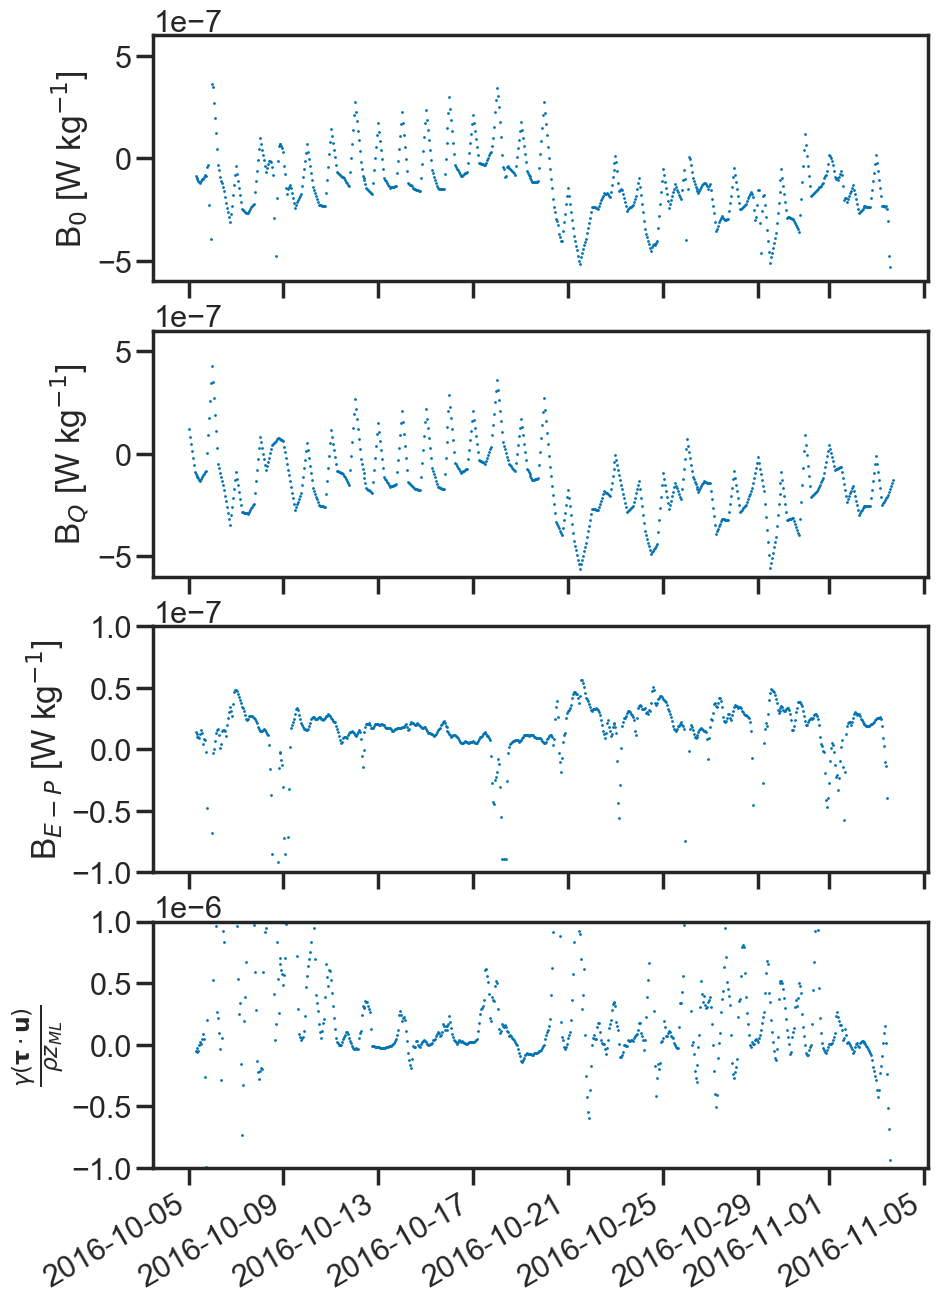

In [38]:
f,ax=plt.subplots(4,1,sharex=True, figsize=(10,15))
# met['uprime'].plot(ax=ax[0],lw=0,marker='.',ms=2)
# ax[0].set_xlabel(None)
# ax[0].set_ylabel(r'u*')
# ax[0].set_ylim(0,2e-6)

met['B'].plot(ax=ax[0],lw=0,marker='.',ms=2)
ax[0].set_xlabel(None)
ax[0].set_ylabel(r'B$_0$ [W kg$^{-1}$]')
ax[0].set_ylim(-6e-7,6e-7)

met['BQ'].plot(ax=ax[1],lw=0,marker='.',ms=2)
ax[1].set_xlabel(None)
ax[1].set_ylabel(r'B$_Q$ [W kg$^{-1}$]')
ax[1].set_ylim(-6e-7,6e-7)

met.BEP.plot(ax=ax[2],lw=0,marker='.',ms=2)
ax[2].set_xlabel(None)
ax[2].set_ylabel(r'B$_{E-P}$ [W kg$^{-1}$]');
ax[2].set_ylim(-1e-7,1e-7);

met.windforcing.plot(ax=ax[3],lw=0,marker='.',ms=2)
ax[3].set_xlabel(None)
ax[3].set_ylabel(r'$\frac{\gamma (\mathbf{\tau} \cdot \mathbf{u})}{\rho z_{ML}}$');
ax[3].set_ylim(-1e-6,1e-6)
ax[3].ticklabel_format(axis='y',style='sci',scilimits=(0,-6))

In [44]:
met['n2z'] = (met.n2*met.z)

(-300, 0)

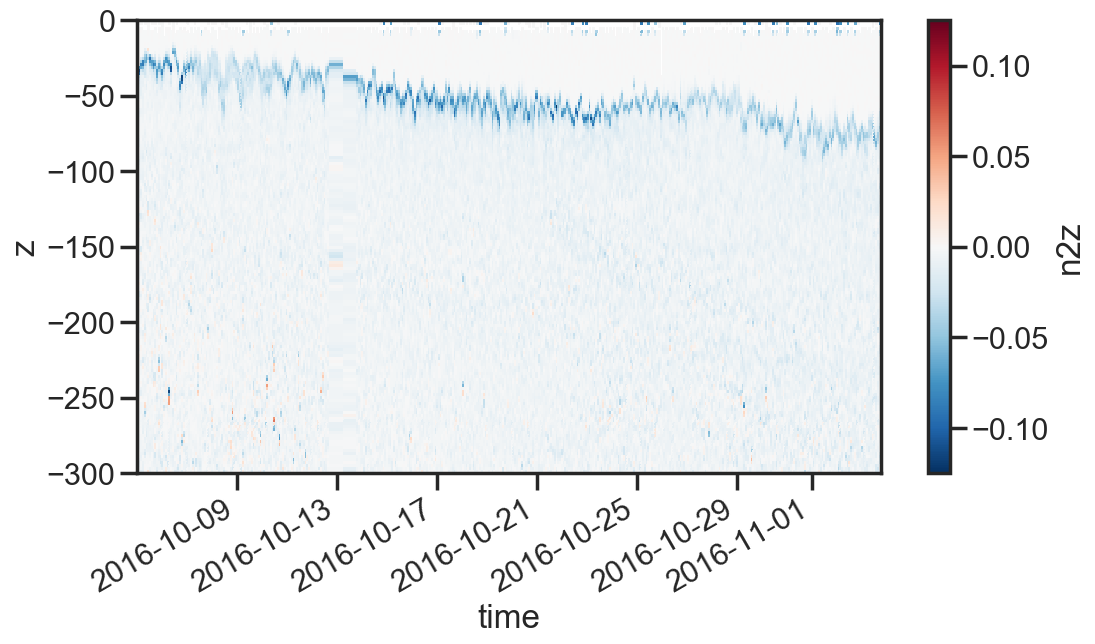

In [47]:
from scipy import integrate

In [84]:
met['n2z'] = (('z','mettime'), met.n2z.interp(time=met.mettime) )

In [193]:
def find_ml_depth(t):
    print(t)
    absolute_error=1e6
    zml = -50
    niter = 0
    
    n2z = met.n2z.isel(mettime=t)
    B0 = met.B.isel(mettime=slice(None,t))
    
    while (absolute_error>0.1) and (niter<1000):
        A = n2z.where(metselect.z > zml).dropna('z').integrate('z')
        B = B0.dropna('mettime').integrate('mettime', datetime_unit='s')
        
        absolute_error = np.abs( A-B )
        
        if A>B:
            zml += .2
        elif B>A:
            zml -= .2
        else:
            break
        niter +=1
        
    return zml

In [194]:
mldepths = [find_ml_depth(t) for t in range(10,len(met.mettime))]

10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
28

KeyboardInterrupt: 

In [202]:
from scipy.optimize import minimize

In [199]:
len( mldepths) 

878

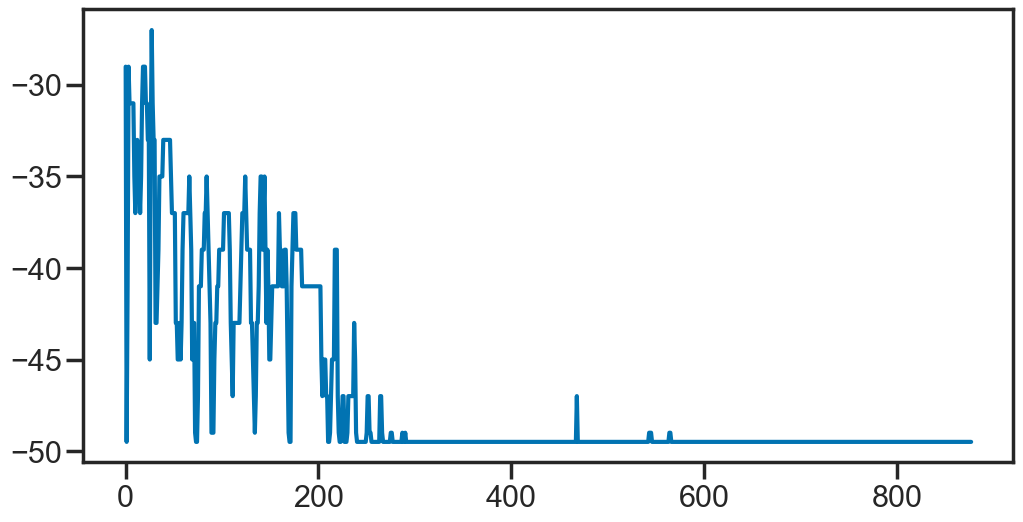

In [201]:
# met.n2z.plot()
# plt.ylim(-300,0)
plt.plot(mldepths)

$$
PE = -g \int_{z_{ML}}^0 \rho (z)z dz
$$